In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [21]:
results = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

### Data

In [22]:
df = pd.read_csv('./data.csv')
# df = pd.read_excel('./data.xlsx')
df.head()

,Company,Custom-Return_x,EPS_MRQ_LC,EPS_TTM,EPS_MRQ,EPS_FY,Rev_TTM,Rev_MRQ,Rev_FY,NI_TTM,...,CFOToDebt,FCFFToRev,FCFFToNI,FCFEToRev,FCFEToNI,CAPEXToRev,CAPEXToNI,DivYield,year,y
0,سرمایه گذاری تامین اجتماعی,NaN,-5.0367,126.0,-5.0,130.0,2.236414e+14,NaN,2.227617e+14,2.065226e+14,...,1.4076,0.6699,0.7075,1.5083,1.7038,0.0002,0.0002,0.1038,1392,0
1,سرمایه گذاری تامین اجتماعی,NaN,-5.0367,126.0,-5.0,130.0,2.236414e+14,NaN,2.227617e+14,2.065226e+14,...,1.4076,0.6699,0.7075,1.5083,1.7038,0.0002,0.0002,0.1038,1400,0
2,سرمایه گذاری تامین اجتماعی,NaN,-5.0367,126.0,-5.0,130.0,2.236414e+14,NaN,2.227617e+14,2.065226e+14,...,1.4076,0.6699,0.7075,1.5083,1.7038,0.0002,0.0002,0.1038,1395,0
3,سرمایه گذاری تامین اجتماعی,NaN,-5.0367,126.0,-5.0,130.0,2.236414e+14,NaN,2.227617e+14,2.065226e+14,...,1.4076,0.6699,0.7075,1.5083,1.7038,0.0002,0.0002,0.1038,1390,0
4,سرمایه گذاری تامین اجتماعی,NaN,-5.0367,126.0,-5.0,130.0,2.236414e+14,NaN,2.227617e+14,2.065226e+14,...,1.4076,0.6699,0.7075,1.5083,1.7038,0.0002,0.0002,0.1038,1393,0


In [23]:
df = df.replace('-', np.nan)
print(df.shape)

(129744, 71)


In [24]:
# drop rows which has no value in TSE_FY or RE_FY column
col_tse_fy = []
col_re_fy = []
for col in df.columns:
    if ('TSE_FY' in col):
        col_tse_fy.append(col)
    if ('RE_FY' in col):
        col_re_fy.append(col)
print(len(col_tse_fy), len(col_re_fy))
print(df.shape)
df = df.dropna(subset=col_tse_fy + col_re_fy, how='all')
print(df.shape)

1 1
(129744, 71)
(119472, 71)


In [25]:
# mean of all col_tse_fy
df['mean_TSE_FY'] = df[col_tse_fy].mean(axis=1)
df['mean_RE_FY'] = df[col_re_fy].mean(axis=1)

# # create a y column RE_FY / TSE_FY > .5 = 1 else 0
# df['y'] = np.where(df['mean_RE_FY'] / df['mean_TSE_FY'] > .5, 1, 0)
print(df.shape)
print('--------')
print(df[df['y'] >= .5].shape)
print(df[df['y'] < .5].shape)

(119472, 73)
--------
(8640, 73)
(110832, 73)


داده‌های گمشده یک مسئله رایج در تجزیه و تحلیل داده است. در بسیاری از موارد، نیاز داریم این داده‌ها را پر کنیم چرا که:

1. **نیاز به تمامیت داده**: بعضی از الگوریتم‌های یادگیری ماشین نمی‌توانند با داده‌های گمشده کار کنند و نیاز به ورودی کامل دارند. اگر این داده‌ها پر نشوند، نمی‌توان از این روش‌ها استفاده کرد.

2. **تاثیر بر تحلیل آماری**: داده‌های گمشده می‌توانند تحلیل‌ها و نتایج آماری را از دست بدهند، و نتایج نادرستی به ما بدهند.

3. **بهره‌برداری از اطلاعات**: اگر مقادیر زیادی از داده‌ها گم شده باشند و آن‌ها را نادیده بگیریم، اطلاعات مفید و معتبری را از دست می‌دهیم که می‌تواند در تصمیم‌گیری مؤثر باشد.

4. **ارتباط بین متغیرها**: داده‌های گمشده می‌توانند روابط بین متغیرها را پنهان کنند و تحلیل‌ها را سخت‌تر کنند. با پر کردن داده‌های گمشده، می‌توان ارتباطات موجود را بررسی و درک بهتری از ساختار داده داشت.

5. **یکپارچگی داده‌ها**: در برخی موارد، داده‌ها از منابع مختلف جمع‌آوری می‌شوند که ممکن است فرمت‌ها و ساختارهای متفاوتی داشته باشند. پر کردن داده‌های گمشده می‌تواند به یکپارچگی و همگنی بیشتر کمک کند.

6. **اجتناب از سوءتفاهم**: داده‌های گمشده می‌توانند به سوءتفاهم منجر شوند و به اشتباه تفسیر شوند. با پر کردن این مقادیر، می‌توان از این سوءتفاهم‌ها جلوگیری کرد.

با وجود این، روش پر کردن داده‌ها بسیار حساس است و باید با دقت انتخاب شود. انتخاب یک روش نامناسب می‌تواند به جای بهبود، مشکلات بیشتری ایجاد کند. از طرف دیگر، گاهی اوقات ممکن است حذف داده‌های گمشده (اگر تعداد آن‌ها کم باشد) به جای پر کردن آن‌ها، گزینه مناسب‌تری باشد. همچنین باید توجه داشت که اگر میزان داده‌های گمشده بسیار زیاد باشد، ممکن است نتوان از داده‌ها استفاده موثری کرد، و باید به جمع‌آوری دوباره داده یا استفاده از منابع دیگر فکر کرد.

In [26]:
# print nan proportion
print(df.isna().sum() / df.shape[0])

Company            0.000000
Custom-Return_x    0.383889
EPS_MRQ_LC         0.193451
EPS_TTM            0.018080
EPS_MRQ            0.019687
                     ...   
DivYield           0.270482
year               0.000000
y                  0.000000
mean_TSE_FY        0.000000
mean_RE_FY         0.006027
Length: 73, dtype: float64


1. **میانگین (Mean)**: این روش با استفاده از میانگین ستون‌ها مقادیر گمشده را پر می‌کند.
   ```python
   df = df.fillna(df.mean())
   ```
   اگر یک ستون مقادیر عددی داشته باشد، میانگین مقادیر موجود این ستون برای مقادیر گمشده این ستون استفاده می‌شود. این روش برای داده‌هایی که توزیع نرمال دارند مفید است.

2. **میانه (Median)**: این روش با استفاده از میانه‌ی ستون‌ها مقادیر گمشده را پر می‌کند.
   ```python
   df = df.fillna(df.median())
   ```
   میانه، مقداری است که نصف داده‌ها بیشتر از آن هستند و نصف دیگر کمتر. این روش نسبت به میانگین به داده‌های پرت حساس نیست و برای توزیع‌های نامتقارن مناسب‌تر است.

3. **مُد (Mode)**: مُد، مقداری است که بیشتر از هر مقدار دیگر در داده‌ها تکرار شده است. این روش با استفاده از مُد ستون‌ها مقادیر گمشده را پر می‌کند.
   ```python
   df = df.fillna(df.mode().iloc[0])
   ```
   این روش برای ستون‌های دسته‌ای مناسب است که مقادیر گسسته دارند.

4. **پر کردن با صفر**: این روش به سادگی هر مقدار گمشده را با صفر جایگزین می‌کند.
   ```python
   df = df.fillna(0)
   ```
   این روش برخی مواقع مفید است، ولی باید با احتیاط استفاده شود، زیرا می‌تواند تغییرات ناخواسته‌ای در توزیع داده‌ها ایجاد کند.


بسته به ویژگی‌های داده و معیارهای تجزیه و تحلیل، ممکن است یکی از این روش‌ها از دیگران بهتر عمل کند. انتخاب بهینه‌ترین روش نیاز به تجزیه و تحلیل و درک دقیق از داده‌ها و مسئله‌ی مورد بررسی دارد.

In [27]:
# df = df.fillna(df.mean())
# df = df.fillna(df.median())
# df = df.fillna(df.mode().iloc[0])

# fill NaN with 0
df = df.fillna(0)

print(df.isna().sum() / df.shape[0])

Company            0.0
Custom-Return_x    0.0
EPS_MRQ_LC         0.0
EPS_TTM            0.0
EPS_MRQ            0.0
                  ... 
DivYield           0.0
year               0.0
y                  0.0
mean_TSE_FY        0.0
mean_RE_FY         0.0
Length: 73, dtype: float64


استفاده از `MinMaxScaler` در کتابخانه‌ی Scikit-learn یکی از روش‌های متداول برای نرمال‌سازی داده‌ها است. اما ابتدا بیایید ببینیم که نرمال‌سازی چیست و چرا انجام می‌شود:

### نرمال‌سازی چیست؟
نرمال‌سازی یا نرمال کردن داده‌ها به معنای تغییر مقیاس داده‌ها به طوری است که تمام ویژگی‌ها (ستون‌ها) در مقیاس مشابه‌ای قرار گیرند. مقیاس معمول بین 0 و 1 است یا -1 و 1.

### چرا نرمال‌سازی مهم است؟
1. **سرعت آموزش**: الگوریتم‌های یادگیری ماشین با داده‌هایی که در مقیاس مشابهی هستند، معمولاً سریع‌تر آموزش می‌بینند.
2. **کم‌تر شدن احتمال به اشتباه رفتن به مینیمم‌های محلی**: در الگوریتم‌هایی مانند گرادیان کاهشی که از مشتق استفاده می‌کنند، اگر یک ویژگی در مقیاس بسیار بزرگ‌تری باشد، ممکن است الگوریتم به مینیمم‌های محلی گرفتار شود.
3. **وزن‌دهی عادلانه به ویژگی‌ها**: اگر مقیاس ویژگی‌ها متفاوت باشد، ویژگی با مقیاس بزرگ‌تر وزن بیشتری در مدل خواهد داشت، حتی اگر اهمیت ویژه‌ای نداشته باشد.

### `MinMaxScaler`
`MinMaxScaler` یکی از روش‌های نرمال‌سازی است که هر ویژگی را به مقیاس مشخص (معمولاً بین 0 و 1) تغییر می‌دهد. فرمول آن به صورت زیر است:

\[ X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} \]

که در آن \(X_{\text{min}}\) و \(X_{\text{max}}\) به ترتیب کمترین و بزرگ‌ترین مقادیر هر ویژگی هستند.

### نحوه استفاده از `MinMaxScaler`
برای استفاده از `MinMaxScaler` در Scikit-learn، ابتدا باید یک شیء از آن ایجاد کرده و سپس متد `fit_transform` را روی داده‌ها فراخوانی کنید:

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
```

این کار باعث می‌شود هر ویژگی در `data` بین 0 و 1 قرار گیرد.

دقت کنید که نرمال‌سازی می‌تواند تاثیر مثبتی بر بسیاری از الگوریتم‌های یادگیری ماشین داشته باشد، اما همیشه لازم نیست و بستگی به مدل و داده‌ها دارد.

In [28]:
# Scaler
scaler = MinMaxScaler()
cols_to_scale = df.columns
# remove Company, y, year from cols_to_scale
cols_to_scale = [col for col in cols_to_scale if col not in ['Company', 'y', 'year']]
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df.head()

,Company,Custom-Return_x,EPS_MRQ_LC,EPS_TTM,EPS_MRQ,EPS_FY,Rev_TTM,Rev_MRQ,Rev_FY,NI_TTM,...,FCFFToNI,FCFEToRev,FCFEToNI,CAPEXToRev,CAPEXToNI,DivYield,year,y,mean_TSE_FY,mean_RE_FY
0,سرمایه گذاری تامین اجتماعی,8.317413e-07,0.31629,2.605870e-10,0.999973,0.001849,0.107346,0.054275,0.107098,0.526337,...,0.896667,0.991152,0.453948,0.978933,0.655837,0.152333,1392,0,1.0,0.74384
1,سرمایه گذاری تامین اجتماعی,8.317413e-07,0.31629,2.605870e-10,0.999973,0.001849,0.107346,0.054275,0.107098,0.526337,...,0.896667,0.991152,0.453948,0.978933,0.655837,0.152333,1400,0,1.0,0.74384
2,سرمایه گذاری تامین اجتماعی,8.317413e-07,0.31629,2.605870e-10,0.999973,0.001849,0.107346,0.054275,0.107098,0.526337,...,0.896667,0.991152,0.453948,0.978933,0.655837,0.152333,1395,0,1.0,0.74384
3,سرمایه گذاری تامین اجتماعی,8.317413e-07,0.31629,2.605870e-10,0.999973,0.001849,0.107346,0.054275,0.107098,0.526337,...,0.896667,0.991152,0.453948,0.978933,0.655837,0.152333,1390,0,1.0,0.74384
4,سرمایه گذاری تامین اجتماعی,8.317413e-07,0.31629,2.605870e-10,0.999973,0.001849,0.107346,0.054275,0.107098,0.526337,...,0.896667,0.991152,0.453948,0.978933,0.655837,0.152333,1393,0,1.0,0.74384


این کد بخشی از فرآیند آماده‌سازی داده برای یادگیری ماشین است و داده‌ها را به دو دسته آموزش (train) و آزمون (test) تقسیم می‌کند. بیایید به توضیح هر بخش بپردازیم:

### تقسیم ستون‌ها
ابتدا ستون‌های مستقل (ویژگی‌ها) و ستون وابسته (هدف یا برچسب) را از یکدیگر جدا می‌کنیم:
- `x_cols` شامل نام همه‌ی ستون‌هایی است که ستون هدف (`y`) نیست.
- `df[x_cols]` شامل مقادیر ویژگی‌ها و `df['y']` شامل مقادیر هدف است.

### تقسیم به دسته‌های آموزش و آزمون
دستور `train_test_split` از کتابخانه‌ی Scikit-learn داده‌ها را به دو دسته آموزش و آزمون تقسیم می‌کند:

- `x_train` و `y_train`: داده‌های ورودی و هدف برای مجموعه آموزش. این داده‌ها برای آموزش مدل استفاده می‌شوند.
- `x_test` و `y_test`: داده‌های ورودی و هدف برای مجموعه آزمون. این داده‌ها برای ارزیابی عملکرد مدل استفاده می‌شوند و نباید در فرآیند آموزش مدل دخیل شوند.

### پارامتر `test_size`
این پارامتر نشان‌دهنده‌ی نسبت داده‌های آزمون است. مقدار `0.2` به این معناست که 20 درصد از داده‌ها به عنوان داده آزمون و باقی‌مانده به عنوان داده آموزش استفاده می‌شود.

### پارامتر `random_state`
این پارامتر می‌تواند به عنوان یک دانه (seed) برای تولید تصادفی استفاده شود. وقتی یک عدد ثابت به عنوان `random_state` ارسال می‌شود، تقسیم‌بندی داده‌ها هر بار که کد اجرا می‌شود یکسان است. این کمک می‌کند تا نتایج قابل تکرار باشند، که در تحقیقات علمی مهم است.

### نتایج چاپی
نتایج چاپی ابعاد هر یک از این مجموعه‌ها را نشان می‌دهد، که می‌تواند به شما درک بهتری از تقسیم‌بندی داده به شما بدهد.

In [29]:
def sampled_train_test_split(df, n_features, info=False):
    x_cols = [col for col in df.columns if col not in ['y', 'Company', 'year']]
    if n_features != 0:
        x_cols = np.random.choice(x_cols, n_features, replace=False)
    if info:
        x_cols = np.append(x_cols, ['Company', 'year'])
    

    x_train, x_test, y_train, y_test = train_test_split(df[x_cols], df['y'], test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = sampled_train_test_split(df, 30)

print('x_train.shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

x_train.shape: (95577, 30)
x_test.shape: (23895, 30)
y_train.shape: (95577,)
y_test.shape: (23895,)


### Metrics
- [x] Accuracy
- [x] Precision
- [x] Recall
- [x] F1
- [x] ROC AUC

این شاخص‌های ارزیابی متداول در مسائل طبقه‌بندی هستند و برای ارزیابی عملکرد مدل در پیش‌بینی ورشکستگی شرکت‌ها می‌توان از آن‌ها استفاده کرد. بیایید به توضیح هر یک از این شاخص‌ها بپردازیم:

### Accuracy (دقت)
**فرمول**: \(\text{Accuracy} = \frac{\text{تعداد پیش‌بینی‌های صحیح}}{\text{تعداد کل پیش‌بینی‌ها}}\)

**توضیح**: دقت نشان‌دهنده‌ی تعداد پیش‌بینی‌های صحیح بر تعداد کل پیش‌بینی‌ها است. در مسائلی که توزیع کلاس‌ها متعادل است، می‌توان از دقت به عنوان یک شاخص مناسب استفاده کرد.

### Precision (دقت اثر)
**فرمول**: \(\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Positives (FP)}}\)

**توضیح**: دقت اثر نشان‌دهنده‌ی تعداد پیش‌بینی‌های مثبت صحیح بر تعداد کل پیش‌بینی‌های مثبت است. این شاخص در مواردی که هزینه‌ی پیش‌بینی مثبت اشتباه بالا است، مفید است.

### Recall (بازیابی)
**فرمول**: \(\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}\)

**توضیح**: بازیابی نشان‌دهنده‌ی تعداد پیش‌بینی‌های مثبت صحیح بر تعداد کل موارد مثبت واقعی است. این شاخص در مواردی که هزینه‌ی پیش‌بینی منفی اشتباه بالا است، مفید است.

### F1 Score (نمره F1)
**فرمول**: \(\text{F1} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}\)

**توضیح**: نمره F1 میانگین هارمونیک دقت اثر و بازیابی است و در مواردی که توازن بین دقت اثر و بازیابی مهم است، استفاده می‌شود.

### ROC AUC (ناحیه زیر منحنی ROC)
**توضیح**: ROC AUC مساحت زیر منحنی ROC است. منحنی ROC با محور افقی نرخ مثبت اشتباه (FPR) و محور عمودی نرخ مثبت صحیح (TPR) رسم می‌شود. مقدار ROC AUC بین 0 و 1 است، و مقدار بالاتر نشان‌دهنده‌ی عملکرد بهتر است. این شاخص در مواردی که توازن بین نرخ مثبت صحیح و نرخ مثبت اشتباه مهم است، مفید است.

### استفاده از این شاخص‌ها در مسئله پیش‌بینی ورشکستگی
در مسئله‌ی پیش‌بینی ورشکستگی، هر یک از این شاخص‌ها می‌تواند مفید باشد بسته به اهداف و محدودیت‌های تجاری. به عنوان مثال، اگر هزینه‌ی پیش‌بینی اشتباه ورشکستگی بسیار بالا باشد، ممکن است بخواهید بر روی بازیابی تمرکز کنید. اگر همچنین می‌خواهید توازنی بین دقت اثر و بازیابی داشته باشید، نمره 
F1 می‌تواند شاخص مناسبی باشد.

### Logistic Regression

مدل رگرسیون لجستیک یکی از الگوریتم‌های معروف طبقه‌بندی است که برای پیش‌بینی احتمال وقوع یک پدیده مورد استفاده قرار می‌گیرد. در این مورد، مدل برای پیش‌بینی احتمال ورشکستگی یک شرکت استفاده شده است.

### پیشینه و منطق
رگرسیون لجستیک به منظور مدل‌سازی احتمال وقوع یک پدیده باینری استفاده می‌شود. این مدل از تابع لجستیک (یا سیگموئید) استفاده می‌کند تا احتمال وقوع پدیده را محاسبه کند. تابع لجستیک به صورت زیر است:

\[ f(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \ldots + \beta_n x_n)}} \]

که در آن \( \beta_0, \beta_1, \ldots, \beta_n \) پارامتر‌های مدل و \( x_1, \ldots, x_n \) ویژگی‌های ورودی هستند.

### استفاده از مدل برای این مسءله
در مسءله‌ی پیش‌بینی ورشکستگی، ویژگی‌ها ممکن است شامل نسبت‌ها و مؤلفه‌های مالی شرکت باشند. رگرسیون لجستیک می‌تواند ارتباط بین این ویژگی‌ها و احتمال ورشکستگی را یاد بگیرد.

### پارامتر‌ها
در کد ارائه شده، از تنظیمات پیش‌فرض برای مدل استفاده شده است. اما می‌توان برخی از پارامتر‌های زیر را تنظیم کرد:

- `penalty`: نوع نرمال‌سازی مورد استفاده، مانند "l1" یا "l2".
- `C`: نمایانگر وارون قدرت نرمال‌سازی است. مقدار کمتر معادل نرمال‌سازی قوی‌تر است.
- `fit_intercept`: آیا باید یک اصطلاح انحرافی در مدل داشته باشیم یا خیر.
- `solver`: روش بهینه‌سازی برای پیدا کردن پارامتر‌ها.

### نتیجه‌گیری
رگرسیون لجستیک یک روش مناسب برای مسءله‌ی پیش‌بینی ورشکستگی می‌باشد زیرا از ویژگی‌های مالی به عنوان ورودی استفاده می‌کند تا یک احتمال برای ورشکستگی تخمین بزند. تنظیم مناسب پارامتر‌ها می‌تواند به بهبود عملکرد مدل کمک کند، بسته به مجموعه داده و اهداف.

In [30]:
logistic_model = LogisticRegression()

x_train, x_test, y_train, y_test = sampled_train_test_split(df, 0)

logistic_model.fit(x_train, y_train)

/home/smbh/.venvs/cbp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

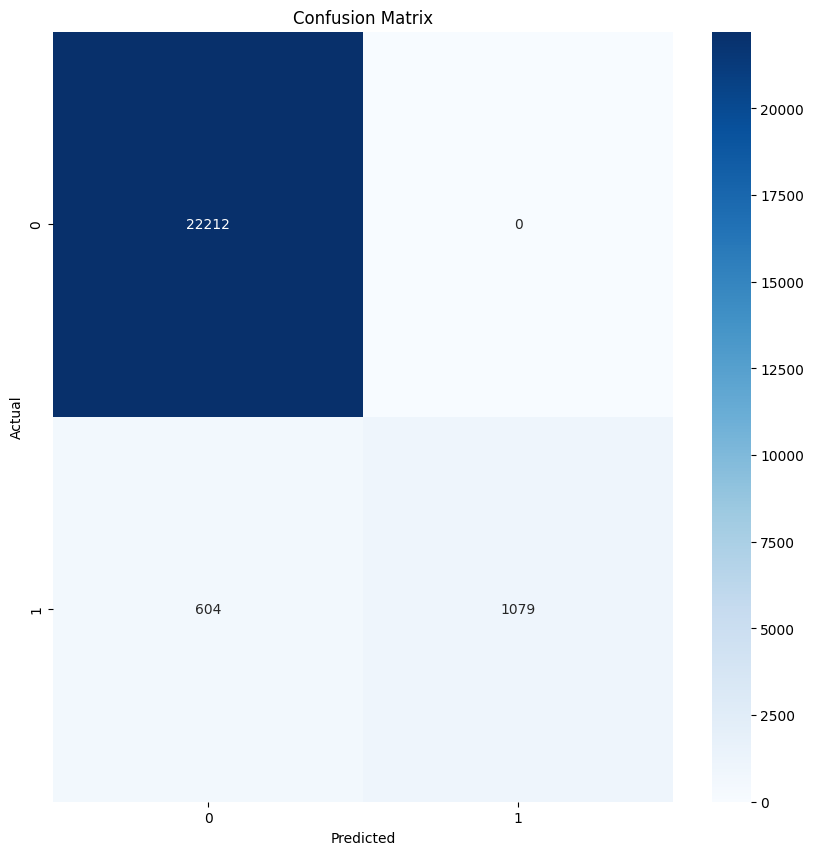

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747        1.0  0.6411  0.7813   0.8206


In [31]:
# evaluate the model
y_pred = logistic_model.predict(x_test)

# plot confusion matrix (show each cell's count)
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# save confusion matrix as image
fig.savefig('LR_confusion_matrix.png')

results.loc[len(results)] = [
    'Logistic Regression', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(precision_score(y_test, y_pred), 4), 
    round(recall_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4), 
    round(roc_auc_score(y_test, y_pred), 4)
]
print(results)

### SVM

مدل پشتیبانی بردار ماشین (SVM) با هسته چندجمله‌ای یکی از الگوریتم‌های معروف برای طبقه‌بندی و پیش‌بینی است. در اینجا، مدل به منظور پیش‌بینی ورشکستگی شرکت‌ها استفاده شده است.

### پیشینه و منطق
ماشین بردار پشتیبانی (SVM) یک الگوریتم طبقه‌بندی است که می‌کوشد یک صفحه یا فضای تصمیم بسازد تا دسته‌ها را به بهترین شکل از هم جدا کند. ایده اصلی این است که یک مرز تصمیم یا "جاده" را پیدا کند که بیشترین فاصله را از نمونه‌های نزدیک‌ترین هر دو کلاس داشته باشد.

هسته چندجمله‌ای امکان می‌دهد تا داده‌ها را به فضایی با بعد بالاتر ببرد، جایی که داده‌ها به صورت خطی قابل جدا سازی باشند. فرمول هسته چندجمله‌ای به شکل زیر است:

\[ K(x, y) = (r + \gamma \langle x, y \rangle )^d \]

که در آن \( r \)، \( \gamma \) و \( d \) پارامتر‌های هسته هستند.

### استفاده از مدل برای این مسءله
SVM با هسته چندجمله‌ای می‌تواند برای پیش‌بینی ورشکستگی مورد استفاده قرار گیرد، به خصوص اگر روابط غیرخطی بین ویژگی‌ها و هدف وجود داشته باشد. انتخاب هسته چندجمله‌ای به مدل اجازه می‌دهد تا از این روابط پیچیده یاد بگیرد.

### پارامتر‌ها
- `kernel`: نوع هسته، در این مورد "poly" برای هسته چندجمله‌ای.
- `degree`: درجه چندجمله‌ای که در این مورد برابر با 3 است.
- `C`: پارامتر نرمال‌سازی. مقدار کمتر معادل نرمال‌سازی قوی‌تر است.
- `random_state`: برای اطمینان از تکرارپذیری نتایج.

### نتیجه‌گیری
SVM با هسته چندجمله‌ای می‌تواند یک روش قدرتمند برای پیش‌بینی ورشکستگی باشد، به خصوص اگر روابط غیرخطی بین ویژگی‌ها و ورشکستگی وجود داشته باشد. تنظیمات مختلف پارامتر‌ها می‌تواند تأثیر زیادی بر کارایی مدل داشته باشد، بنابراین انجام جستجوی گرید برای یافتن بهترین ترکیب پارامتر‌ها ممکن است مفید باشد.

In [32]:
svm_model = SVC(kernel='poly', degree=3, C=1, random_state=42)

x_train, x_test, y_train, y_test = sampled_train_test_split(df, 0)

svm_model.fit(x_train, y_train)

SVC(C=1, kernel='poly', random_state=42)

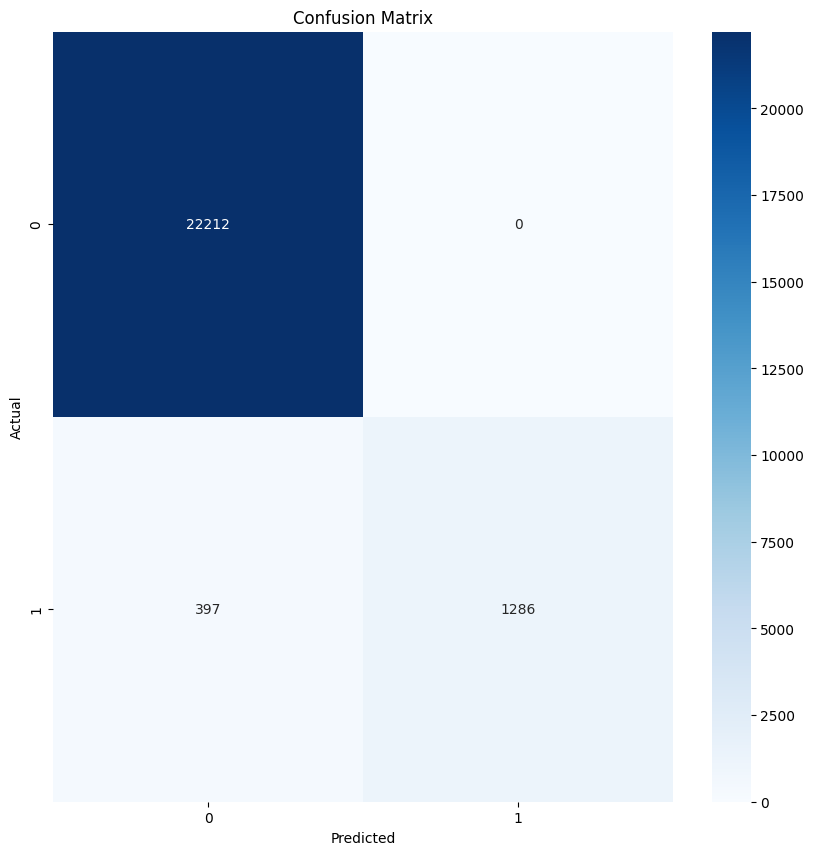

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747        1.0  0.6411  0.7813   0.8206
1                  SVM    0.9834        1.0  0.7641  0.8663   0.8821


In [33]:
y_pred = svm_model.predict(x_test)

# plot confusion matrix (show each cell's count)
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# save confusion matrix as image
fig.savefig('SVM_confusion_matrix.png')

results.loc[len(results)] = [
    'SVM',
    round(accuracy_score(y_test, y_pred), 4),
    round(precision_score(y_test, y_pred), 4),
    round(recall_score(y_test, y_pred), 4),
    round(f1_score(y_test, y_pred), 4),
    round(roc_auc_score(y_test, y_pred), 4)
]
print(results)

### Random Forest

مدل جنگل تصادفی (Random Forest) یکی از روش‌های بسیار محبوب و قدرتمند در یادگیری ماشین است که برای طبقه‌بندی و رگرسیون استفاده می‌شود. در این مورد، مدل برای پیش‌بینی ورشکستگی شرکت‌ها استفاده شده است.

### پیشینه و منطق
جنگل تصادفی یک ترکیب از درختان تصمیم است که به طور مستقل آموزش داده می‌شوند. هر درخت تصمیم یک پیش‌بینی می‌دهد، و پیش‌بینی نهایی از رأی‌گیری بین تمام درختان به دست می‌آید.

مزیت اصلی جنگل تصادفی نسبت به درخت تصمیم تنها این است که از برازش بیش از حد (overfitting) جلوگیری می‌کند. در حالی که یک درخت تصمیم ممکن است بر روی داده‌های آموزشی برازش بیش از حد کند، ترکیب چندین درخت کمتر مستعد این مشکل است.

### استفاده از مدل برای این مسءله
جنگل تصادفی می‌تواند یک انتخاب مناسب برای پیش‌بینی ورشکستگی باشد، زیرا این مدل می‌تواند روابط پیچیده و غیرخطی بین ویژگی‌ها و ورشکستگی را بیاموزد. این مدل همچنین می‌تواند اهمیت هر ویژگی را ارزیابی کند، که می‌تواند برای تحلیل تأثیر مؤلفه‌های مختلف مالی بر ورشکستگی مفید باشد.

### پارامتر‌ها
- `n_estimators`: تعداد درختان در جنگل. در این مورد برابر با 100 است.
- `max_depth`: عمق حداکثری هر درخت. در این مورد برابر با 4 است.
- `random_state`: برای اطمینان از تکرارپذیری نتایج.

### نتیجه‌گیری
جنگل تصادفی با قدرت ترکیب چندین درخت تصمیم، می‌تواند یک مدل قوی و پایدار برای پیش‌بینی ورشکستگی ارائه دهد. این مدل می‌تواند روابط غیرخطی را نیز به خوبی مدل کند، و از برازش بیش از حد جلوگیری کند. تنظیم مناسب پارامتر‌ها می‌تواند به بهبود عملکرد مدل کمک کند. تجزیه و تحلیل اهمیت ویژگی‌ها همچنین می‌تواند ارزشمند باشد برای فهمیدن چه عوامل مالی بیشترین تأثیر را بر ورشکستگی د

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)

x_train, x_test, y_train, y_test = sampled_train_test_split(df, 0, True)
x_test_copy = x_test.copy()
# drop Company and year
x_test = x_test.drop(['Company', 'year'], axis=1)
x_train = x_train.drop(['Company', 'year'], axis=1)

In [35]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

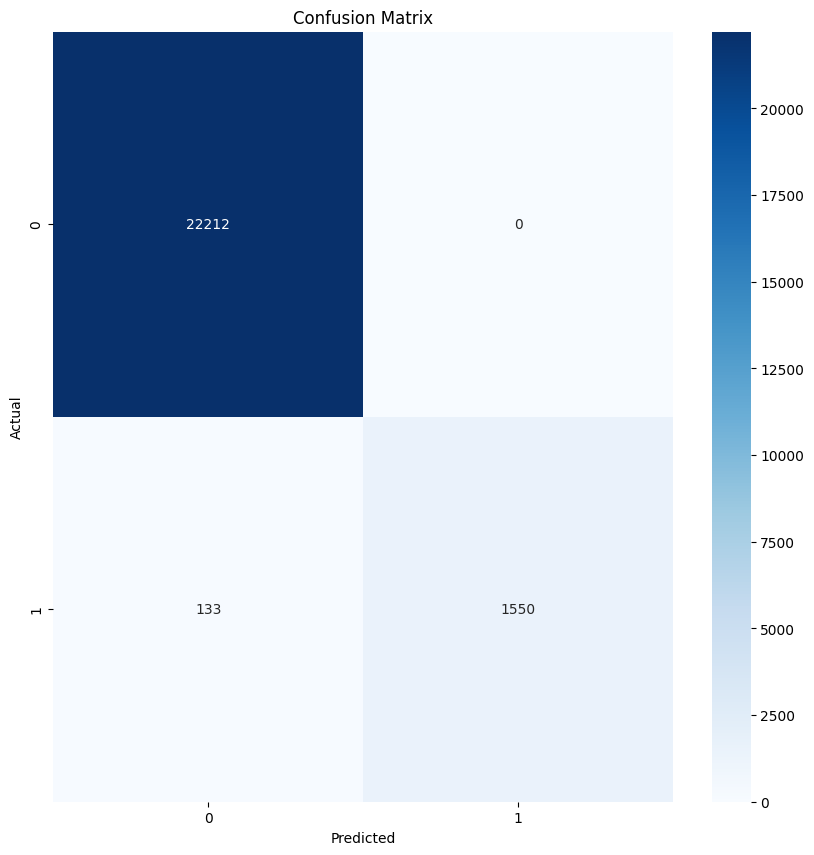

In [36]:
y_pred = rf_model.predict(x_test)

# plot confusion matrix (show each cell's count)
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# save confusion matrix as image
fig.savefig('RF_confusion_matrix.png')

In [37]:
x_test_copy["y"] = y_test
x_test_copy["y_pred"] = y_pred
# filter only year == 1401, 1400
x_test_copy = x_test_copy[x_test_copy["year"].isin([1401, 1400])]
# filter unique Company for each year
x_test_copy = x_test_copy.drop_duplicates(subset=["year", "Company"])
# print count of y_pred > .5
x_test_copy.to_csv("RF.csv", index=False)
x_test_copy.to_excel("RF.xlsx", index=False)
print(x_test_copy[x_test_copy["y_pred"] > .5].shape)
print(x_test_copy.shape)
x_test_copy.head()

(104, 74)
(1535, 74)


,Custom-Return_x,EPS_MRQ_LC,EPS_TTM,EPS_MRQ,EPS_FY,Rev_TTM,Rev_MRQ,Rev_FY,NI_TTM,NI_MRQ,...,FCFEToNI,CAPEXToRev,CAPEXToNI,DivYield,mean_TSE_FY,mean_RE_FY,Company,year,y,y_pred
37846,1.633866e-06,0.330062,2.713168e-10,0.999974,0.001850,0.047686,0.057833,0.047360,0.330663,0.500466,...,0.441731,0.978933,0.655837,0.279718,0.367658,0.615849,سرمایه‌گذاری‌توسعه‌ملی‌,1401,0,0
100717,8.317413e-07,0.334688,2.756709e-10,0.999974,0.001850,0.047071,0.057338,0.047071,0.321483,0.496425,...,0.441336,0.978934,0.656128,0.006751,0.363822,0.610609,الحاوی,1400,0,0
114121,8.317413e-07,0.316462,2.595299e-10,0.999973,0.001849,0.044987,0.054800,0.044887,0.320667,0.495816,...,0.439617,0.978933,0.655836,0.000000,0.361994,0.609331,لیزینگ اقتصاد نوین,1400,0,0
30706,1.179648e-06,0.346588,2.703017e-10,0.999974,0.001850,0.120623,0.243416,0.120623,0.396603,0.577509,...,0.446629,0.978935,0.656219,0.034781,0.422019,0.675757,گروه مپنا (سهامی عام),1401,0,0
104137,5.154504e-07,0.316110,2.594460e-10,0.999973,0.001849,0.044520,0.054294,0.044520,0.319372,0.495486,...,0.439617,0.978941,0.653473,0.000000,0.361380,0.608542,سیمان مجد خواف,1400,0,0


In [38]:
results.loc[len(results)] = [
    'Random Forest',
    round(accuracy_score(y_test, y_pred), 4),
    round(precision_score(y_test, y_pred), 4),
    round(recall_score(y_test, y_pred), 4),
    round(f1_score(y_test, y_pred), 4),
    round(roc_auc_score(y_test, y_pred), 4)
]
print(results)

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747        1.0  0.6411  0.7813   0.8206
1                  SVM    0.9834        1.0  0.7641  0.8663   0.8821
2        Random Forest    0.9944        1.0  0.9210  0.9589   0.9605


### Sequential Data

تغییر شکل داده‌ها و اضافه کردن مجموعه اعتبارسنجی در پردازش داده برای مدل‌های سری زمانی مانند LSTM و RNN ضروری است. بیایید به توضیح این بخش‌ها بپردازیم:

### تغییر شکل داده‌ها
مدل‌های سری زمانی مانند LSTM و RNN به داده‌های ورودی با شکل خاصی نیاز دارند. این مدل‌ها با فرض اینکه داده‌ها دارای ترتیب زمانی هستند کار می‌کنند، پس ورودی‌ها باید به شکل `[نمونه‌ها، گام‌های زمانی، ویژگی‌ها]` باشند.

در این مورد:
- `نمونه‌ها`: تعداد کل رکوردها یا مشاهدات.
- `گام‌های زمانی`: تعداد گام‌ها در هر سری زمانی. در این مورد برابر با 1 است.
- `ویژگی‌ها`: تعداد ویژگی‌ها یا متغیرهای مستقل در هر گام زمانی.

تابع `reshape` به ما کمک می‌کند تا ابعاد داده‌ها را به شکل مورد نیاز تغییر دهیم.

### تقسیم داده‌ها
در این مورد، داده‌ها به سه بخش تقسیم می‌شوند:
- **آموزش (70% از داده‌ها)**: این بخش برای آموزش مدل استفاده می‌شود.
- **اعتبارسنجی (15% از داده‌ها)**: این بخش برای ارزیابی عملکرد مدل در حین آموزش و تنظیم پارامتر‌ها استفاده می‌شود.
- **تست (15% از داده‌ها)**: این بخش برای ارزیابی نهایی عملکرد مدل استفاده می‌شود.

### اهمیت اضافه کردن مجموعه اعتبارسنجی
استفاده از مجموعه اعتبارسنجی کمک می‌کند تا بتوانید عملکرد مدل را در حین آموزش ارزیابی کنید، بدون اینکه به مجموعه تست دسترسی داشته باشید. این امر می‌تواند جلوی برازش بیش از حد روی داده‌های آموزش را بگیرد و به شما اجازه دهد تا پارامتر‌های مدل را بهتر تنظیم کنید.

در کل، این تقسیم‌بندی و تغییر شکل داده‌ها ضروری است برای استفاده از مدل‌های سری زمانی و ارزیابی صحیح عملکرد آن‌ها.

In [39]:
# split data
x = df.drop(columns=['y', 'Company', 'year'])
y = df['y']
x = np.array(x)
y = np.array(y)
# [samples, timesteps, features]
x = x.reshape(x.shape[0], 1, x.shape[1])

x_train = x[:int(x.shape[0] * .7)]
y_train = y[:int(y.shape[0] * .7)]
x_valid = x[int(x.shape[0] * .7):int(x.shape[0] * .85)]
y_valid = y[int(y.shape[0] * .7):int(y.shape[0] * .85)]
x_test = x[int(x.shape[0] * .85):]
y_test = y[int(y.shape[0] * .85):]

print(x_train.shape)
print(y_train.shape)
print("------")
print(x_valid.shape)
print(y_valid.shape)
print("------")
print(x_test.shape)
print(y_test.shape)

(83630, 1, 70)
(83630,)
------
(17921, 1, 70)
(17921,)
------
(17921, 1, 70)
(17921,)


In [40]:
# # repplicate data
# REPLICATE = 5
# x_train = np.repeat(x_train, REPLICATE, axis=0)
# y_train = np.repeat(y_train, REPLICATE, axis=0)
# x_valid = np.repeat(x_valid, REPLICATE, axis=0)
# y_valid = np.repeat(y_valid, REPLICATE, axis=0)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(83630, 1, 70)
(83630,)
(17921, 1, 70)
(17921,)


### LSTM

### پیشینه مدل‌های Deep و سری زمانی
مدل‌های Deep Learning، بخصوص مدل‌های سری زمانی مانند LSTM (Long Short-Term Memory)، توانمندی بالایی در کشف الگوها و وابستگی‌های پنهان در داده‌های سری زمانی دارند. این قابلیت‌ها می‌توانند مفید باشند در مواردی که ترتیب و وابستگی زمانی بین نقاط داده مهم است، مانند پیش‌بینی ورشکستگی شرکت‌ها بر اساس داده‌های مالی.

### معرفی مدل LSTM
LSTM یک نوع خاص از RNN (شبکه‌های عصبی بازگشتی) است که برای حل مشکل از دست رفتن گرادیان طراحی شده است. این مشکل معمولاً در آموزش شبکه‌های عصبی بازگشتی عادی اتفاق می‌افتد.

### الگوریتم LSTM
LSTM از واحدهای مخصوصی استفاده می‌کند که می‌توانند اطلاعات را برای مدت زمان طولانی حفظ کنند. این واحدها از سه دروازه بهره‌مند هستند:
- دروازه ورودی: کنترل می‌کند که اطلاعات جدید چقدر به حالت فعلی اضافه شود.
- دروازه فراموشی: کنترل می‌کند که اطلاعات قدیمی چقدر حفظ شود.
- دروازه خروجی: کنترل می‌کند که اطلاعات مربوط به حالت فعلی به خروجی ارسال شود.

### استفاده از LSTM در این مسئله
برای پیش‌بینی ورشکستگی شرکت‌ها، مدل LSTM می‌تواند از داده‌های مالی شرکت‌ها در طول زمان بهره‌مند شود. LSTM توانمندی دارد تا وابستگی‌های زمانی پنهان در این داده‌ها را کشف کند و براساس آن‌ها پیش‌بینی کند.

### هایپر پارامتر‌ها و معماری مدل
- **واحدهای LSTM**: 256 واحد برای هر لایه LSTM انتخاب شده است.
- **ورودی**: ابعاد ورودی به تعداد گام‌های زمانی و ویژگی‌ها تنظیم می‌شود.
- **Dropout**: 0.1 برای جلوگیری از برازش بیش از حد.
- **تابع فعال‌سازی خروجی**: sigmoid برای پیش‌بینی احتمال ورشکستگی.
- **تابع هزینه**: binary_crossentropy برای مسئله طبقه‌بندی دو کلاسه.
- **Optimizer**: Adam.

مدل LSTM با توجه به قدرت خود در کار با سری‌های زمانی، انتخاب مناسبی برای این مسئله به نظر می‌رسد و می‌تواند الگوهای پنهان و پیچیده‌ای را که در داده‌های مالی شرکت‌ها وجود دارد، کشف کند.

البته، در زیر توضیح مختصری از هر لایه در مدل LSTM داریم:

1. **لایه LSTM اول**:
   - **واحدها**: 256 واحد LSTM که هر کدام حافظه داخلی دارند.
   - **input_shape**: ابعاد ورودی به تعداد گام‌های زمانی و ویژگی‌ها.
   - **return_sequences**: تنظیم شده بر True، بدین معنا که خروجی از هر گام زمانی به لایه بعدی ارسال می‌شود.
   - **وظیفه**: پردازش داده‌های سری زمانی و کشف وابستگی‌های زمانی در آنها.

2. **لایه Dropout اول**:
   - **نرخ**: 0.1، یعنی 10٪ از ویژگی‌ها در هر دور آموزش تصادفاً صفر می‌شوند.
   - **وظیفه**: جلوگیری از برازش بیش از حد به داده‌های آموزش.

3. **لایه LSTM دوم**:
   - **واحدها**: 256 واحد LSTM.
   - **return_sequences**: تنظیم شده بر False، بدین معنا که فقط خروجی گام زمانی آخر به لایه بعدی ارسال می‌شود.
   - **وظیفه**: پردازش خروجی لایه LSTM قبلی و کشف الگوها و وابستگی‌های بالاتر.

4. **لایه Dropout دوم**:
   - **نرخ**: 0.1.
   - **وظیفه**: مانند لایه Dropout اول، از برازش بیش از حد جلوگیری می‌کند.

5. **لایه Dense (کاملا متصل)**:
   - **واحدها**: 1، تنها یک واحد خروجی.
   - **تابع فعال‌سازی**: sigmoid، تبدیل خروجی به یک احتمال بین 0 و 1.
   - **وظیفه**: تصمیم‌گیری نهایی براساس ویژگی‌ها و اطلاعات استخراج شده توسط لایه‌های قبلی و ارائه پیش‌بینی نهایی.

این معماری با ترکیب لایه‌های LSTM و Dropout توانمندی دارد تا الگوها و وابستگی‌های پیچیده در داده‌های سری زمانی را کشف کند، در عین حال از برازش بیش از حد جلوگیری می‌کند، که می‌تواند به عملکرد بهتری در داده‌های تست منجر شود.

In [41]:
# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
lstm.add(keras.layers.Dropout(0.1))
lstm.add(keras.layers.LSTM(256, return_sequences=False))
lstm.add(keras.layers.Dropout(0.1))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 256)            334848    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 860417 (3.28 MB)
Trainable params: 860417 (3.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


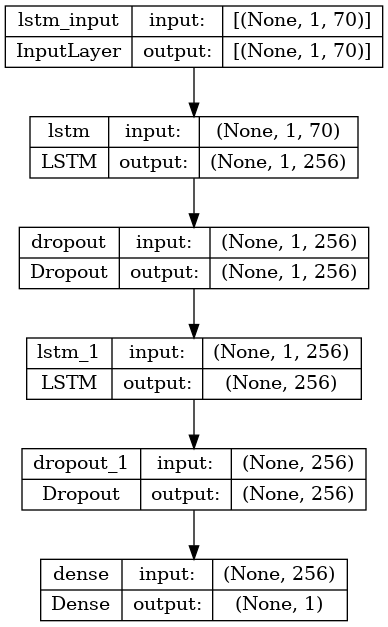

In [42]:
# save plot as image
keras.utils.plot_model(lstm, show_shapes=True, show_layer_names=True, to_file='lstm_model.png')

In [43]:
# train
lstm_history = lstm.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_valid, y_valid), shuffle=False)

Epoch 1/100


327/327 [==============================] - 11s 24ms/step - loss: 0.2182 - accuracy: 0.9465 - val_loss: 0.3248 - val_accuracy: 0.9079
Epoch 2/100
327/327 [==============================] - 7s 23ms/step - loss: 0.2007 - accuracy: 0.9466 - val_loss: 0.3225 - val_accuracy: 0.9079
Epoch 3/100
327/327 [==============================] - 8s 23ms/step - loss: 0.1848 - accuracy: 0.9501 - val_loss: 0.3491 - val_accuracy: 0.9079
Epoch 4/100
327/327 [==============================] - 7s 23ms/step - loss: 0.1678 - accuracy: 0.9580 - val_loss: 0.3819 - val_accuracy: 0.9079
Epoch 5/100
327/327 [==============================] - 7s 22ms/step - loss: 0.1579 - accuracy: 0.9604 - val_loss: 0.3966 - val_accuracy: 0.9079
Epoch 6/100
327/327 [==============================] - 8s 24ms/step - loss: 0.1546 - accuracy: 0.9620 - val_loss: 0.3916 - val_accuracy: 0.9079
Epoch 7/100
327/327 [==============================] - 8s 23ms/step - loss: 0.1493 - accuracy: 0.9622 - val_loss: 0.3804 - val_accuracy: 0.9079
Epo

In [45]:
y_pred.shape, y_test.shape

((17921, 1), (17921,))

165/561 [=======>......................] - ETA: 1s

561/561 [==============================] - 2s 4ms/step


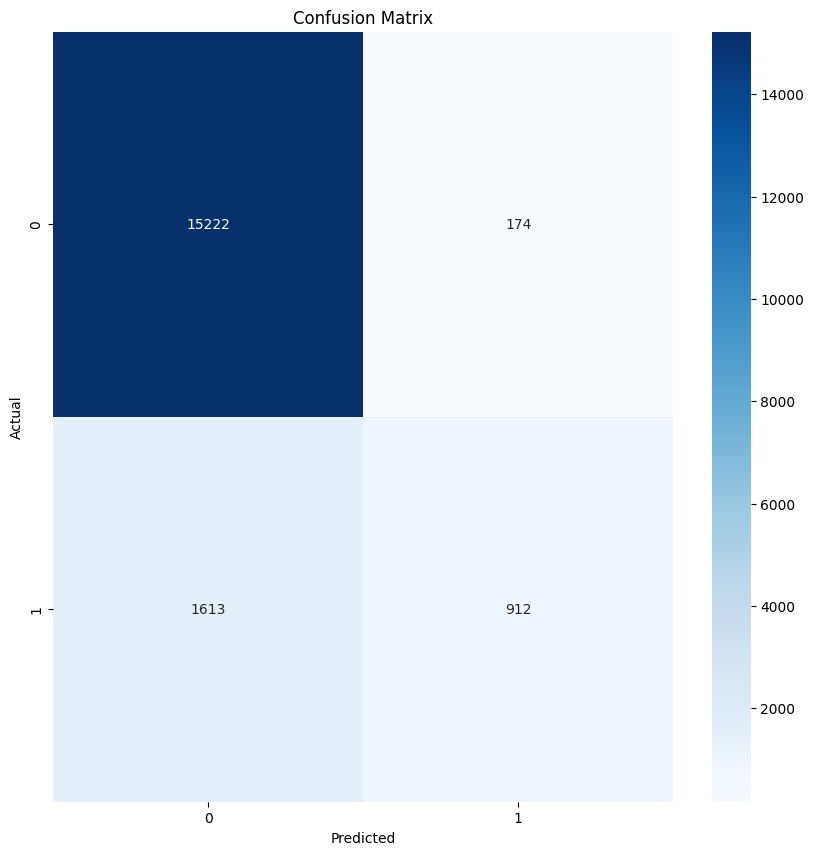

In [52]:
# evaluate the model
y_pred = lstm.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# plot confusion matrix (show each cell's count)
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# save confusion matrix as image
fig.savefig('LSTM_confusion_matrix.png')

In [53]:
# count y_pred > 0.5
print("y_pred > 0.5: ", np.count_nonzero(y_pred > 0.5))

y_pred > 0.5:  1086


In [54]:
# x_test = x[int(x.shape[0] * .85):]
# y_test = y[int(y.shape[0] * .85):]

# add y_pred to original df x_test
rs_x_test = df.iloc[int(df.shape[0] * .85):]
rs_x_test["y_pred"] = y_pred
# filter only year == 1401, 1400
rs_x_test = rs_x_test[rs_x_test["year"].isin([1401, 1400])]
# filter unique Company for each year
rs_x_test = rs_x_test.drop_duplicates(subset=["year", "Company"])
# update columns order move Company, year, y, y_pred to the end
rs_x_test = rs_x_test[["Company", "year", "y", "y_pred"] + [col for col in rs_x_test.columns if col not in ["Company", "year", "y", "y_pred"]]]

rs_x_test.to_csv("LSTM.csv", index=False)
rs_x_test.to_excel("LSTM.xlsx", index=False)
print(rs_x_test[rs_x_test["y_pred"] > .5].shape)
print(rs_x_test.shape)
rs_x_test.head()

/tmp/ipykernel_3646048/2328238636.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(17, 74)
(250, 74)


,Company,year,y,y_pred,Custom-Return_x,EPS_MRQ_LC,EPS_TTM,EPS_MRQ,EPS_FY,Rev_TTM,...,CFOToDebt,FCFFToRev,FCFFToNI,FCFEToRev,FCFEToNI,CAPEXToRev,CAPEXToNI,DivYield,mean_TSE_FY,mean_RE_FY
102166,کارخانجات‌مخابراتی‌ایران‌,1401,1,0.012506,1.029771e-06,0.315105,2.587749e-10,0.999973,0.001849,0.044723,...,0.295552,0.999684,0.895863,0.990956,0.439617,0.978932,0.655881,0.000000,0.362208,0.606595
102169,کارخانجات‌مخابراتی‌ایران‌,1400,1,0.012440,6.139259e-07,0.315105,2.587749e-10,0.999973,0.001849,0.044723,...,0.295557,0.999685,0.895863,0.990980,0.439617,0.978932,0.655904,0.000000,0.362208,0.606595
102241,شرکت کیسون,1400,0,0.000890,1.708071e-06,0.317036,2.618621e-10,0.999973,0.001849,0.056796,...,0.295568,0.999685,0.897166,0.990988,0.385044,0.978927,0.653263,0.052979,0.372974,0.615854
102250,شرکت کیسون,1401,0,0.000839,1.708071e-06,0.317036,2.618621e-10,0.999973,0.001849,0.056796,...,0.295570,0.999685,0.897223,0.990988,0.385044,0.978926,0.653178,0.052979,0.372974,0.615854
102385,کارخانجات کابل سازی‌ تک‌,1400,0,0.002767,1.009970e-06,0.316462,2.614007e-10,0.999974,0.001849,0.044868,...,0.295304,0.999681,0.000000,0.991005,0.428359,0.978935,0.719984,0.000000,0.360533,0.608655


In [55]:
# calc metrics and add a row to results
results.loc[len(results)] = [
    'LSTM',
    round(accuracy_score(y_test, y_pred.round()), 4),
    round(precision_score(y_test, y_pred.round()), 4),
    round(recall_score(y_test, y_pred.round()), 4),
    round(f1_score(y_test, y_pred.round()), 4),
    round(roc_auc_score(y_test, y_pred.round()), 4),
]
print(results)

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747     1.0000  0.6411  0.7813   0.8206
1                  SVM    0.9834     1.0000  0.7641  0.8663   0.8821
2        Random Forest    0.9944     1.0000  0.9210  0.9589   0.9605
3                 LSTM    0.9003     0.8398  0.3612  0.5051   0.6749


In [56]:
# plot loss
fig = go.Figure()
# fig.add_trace(go.Scatter(y=lstm_history.history['loss'], mode='lines', name='loss'))
fig.add_trace(go.Scatter(y=lstm_history.history['val_loss'], mode='lines', name='val_loss'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

# save figure
fig.write_image("lstm_loss.png")

In [57]:
# plot accuracy
fig = go.Figure()
# fig.add_trace(go.Scatter(y=lstm_history.history['accuracy'], mode='lines', name='accuracy'))
fig.add_trace(go.Scatter(y=lstm_history.history['val_accuracy'], mode='lines', name='val_accuracy'))
fig.update_layout(title='Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

# save figure
fig.write_image("lstm_accuracy.png")

In [58]:
print(len(df.iloc[int(x.shape[0] * .85):]))
print(len(y_test))

# create a df with the predictions and the actual values
df_pred = pd.DataFrame(df.iloc[int(x.shape[0] * .85):])
df_pred['actual'] = y_test
df_pred['pred'] = y_pred
df_pred.head()

17921
17921


,Company,Custom-Return_x,EPS_MRQ_LC,EPS_TTM,EPS_MRQ,EPS_FY,Rev_TTM,Rev_MRQ,Rev_FY,NI_TTM,...,FCFEToNI,CAPEXToRev,CAPEXToNI,DivYield,year,y,mean_TSE_FY,mean_RE_FY,actual,pred
102163,کارخانجات‌مخابراتی‌ایران‌,0.000001,0.315105,2.587749e-10,0.999973,0.001849,0.044723,0.054841,0.044723,0.318584,...,0.439617,0.978932,0.655904,0.0,1391,1,0.362208,0.606595,1,0.012426
102164,کارخانجات‌مخابراتی‌ایران‌,0.000001,0.315105,2.587749e-10,0.999973,0.001849,0.044723,0.054841,0.044723,0.318584,...,0.439617,0.978932,0.655904,0.0,1397,1,0.362208,0.606595,1,0.012425
102165,کارخانجات‌مخابراتی‌ایران‌,0.000001,0.315105,2.587749e-10,0.999973,0.001849,0.044723,0.054841,0.044723,0.318584,...,0.439617,0.978932,0.655904,0.0,1394,1,0.362208,0.606595,1,0.012425
102166,کارخانجات‌مخابراتی‌ایران‌,0.000001,0.315105,2.587749e-10,0.999973,0.001849,0.044723,0.054841,0.044723,0.318584,...,0.439617,0.978932,0.655881,0.0,1401,1,0.362208,0.606595,1,0.012506
102167,کارخانجات‌مخابراتی‌ایران‌,0.000001,0.315105,2.587749e-10,0.999973,0.001849,0.044723,0.054841,0.044723,0.318584,...,0.439617,0.978932,0.655904,0.0,1399,1,0.362208,0.606595,1,0.012426


### RNN

مدل RNN (Recurrent Neural Network) یا شبکه‌های عصبی بازگشتی جزء انواع پایه‌ای از شبکه‌های عصبی هستند که برای پردازش داده‌های سری زمانی یا دنباله‌ها طراحی شده‌اند. این مدل‌ها از واحدهای بازگشتی تشکیل شده‌اند که اطلاعات را از گام به گام زمانی انتقال می‌دهند.

### الگوریتم:
RNN‌ها از یک وزن مشترک برای همه گام‌های زمانی استفاده می‌کنند، و این باعث می‌شود تعداد پارامترها مستقل از طول دنباله باقی بماند. اما معیوب اصلی RNN‌ها مشکل ناپدید شدن گرادیان (vanishing gradient) است که ممکن است آموزش را سخت‌تر کند.

### دلیل انتخاب برای این مسئله:
RNN‌ها می‌توانند الگوها و وابستگی‌های زمانی را در داده‌ها کشف کنند، بنابراین برای مسائل مرتبط با سری زمانی، مانند پیش‌بینی ورشکستگی شرکت‌ها بر اساس داده‌های مالی، مناسب هستند.

### هایپر پارامترها:
- تعداد واحدها: 256
- تابع فعال‌سازی: sigmoid برای لایه آخر

### توضیح لایه‌ها:
1. **لایه SimpleRNN اول**:
   - **واحدها**: 256 واحد بازگشتی.
   - **input_shape**: ابعاد ورودی.
   - **return_sequences**: True، بدین معنا که خروجی از هر گام زمانی ارسال می‌شود.
   - **وظیفه**: پردازش دنباله ورودی و انتقال اطلاعات بین گام‌های زمانی.

2. **لایه SimpleRNN دوم**:
   - **واحدها**: 256 واحد بازگشتی.
   - **return_sequences**: False، تنها خروجی گام زمانی آخر.
   - **وظیفه**: پردازش اطلاعات از لایه قبلی و استخراج ویژگی‌های مرتبط.

3. **لایه Dense (کاملا متصل)**:
   - **واحدها**: 1 واحد خروجی.
   - **تابع فعال‌سازی**: sigmoid.
   - **وظیفه**: تصمیم‌گیری نهایی بر اساس ویژگی‌های استخراج شده.

این معماری می‌تواند برای مسائل سری زمانی پیچیده استفاده شود، اما نکته قابل توجه این است که مدل‌های پیشرفته‌تر مانند LSTM معمولاً عملکرد بهتری دارند، به خصوص در دنباله‌های طولانی.

In [59]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.SimpleRNN(256, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
rnn_model.add(keras.layers.Dropout(0.1))
rnn_model.add(keras.layers.SimpleRNN(256, return_sequences=False))
rnn_model.add(keras.layers.Dropout(0.1))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 256)            83712     
                                                                 
 dropout_2 (Dropout)         (None, 1, 256)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 215297 (841.00 KB)
Trainable params: 215297 (841.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
# train
rnn_history = rnn_model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_valid, y_valid), shuffle=False)

Epoch 1/100


327/327 [==============================] - 5s 11ms/step - loss: 0.2212 - accuracy: 0.9473 - val_loss: 0.3990 - val_accuracy: 0.9079
Epoch 2/100
327/327 [==============================] - 3s 10ms/step - loss: 0.1896 - accuracy: 0.9523 - val_loss: 0.3981 - val_accuracy: 0.9079
Epoch 3/100
327/327 [==============================] - 3s 10ms/step - loss: 0.1723 - accuracy: 0.9597 - val_loss: 0.4100 - val_accuracy: 0.9079
Epoch 4/100
327/327 [==============================] - 3s 10ms/step - loss: 0.1626 - accuracy: 0.9603 - val_loss: 0.4141 - val_accuracy: 0.9079
Epoch 5/100
327/327 [==============================] - 3s 9ms/step - loss: 0.1565 - accuracy: 0.9610 - val_loss: 0.3891 - val_accuracy: 0.9079
Epoch 6/100
327/327 [==============================] - 3s 10ms/step - loss: 0.1503 - accuracy: 0.9636 - val_loss: 0.3676 - val_accuracy: 0.9092
Epoch 7/100
327/327 [==============================] - 3s 10ms/step - loss: 0.1421 - accuracy: 0.9648 - val_loss: 0.3574 - val_accuracy: 0.9239
Epoch

  1/561 [..............................] - ETA: 1:31

561/561 [==============================] - 1s 2ms/step


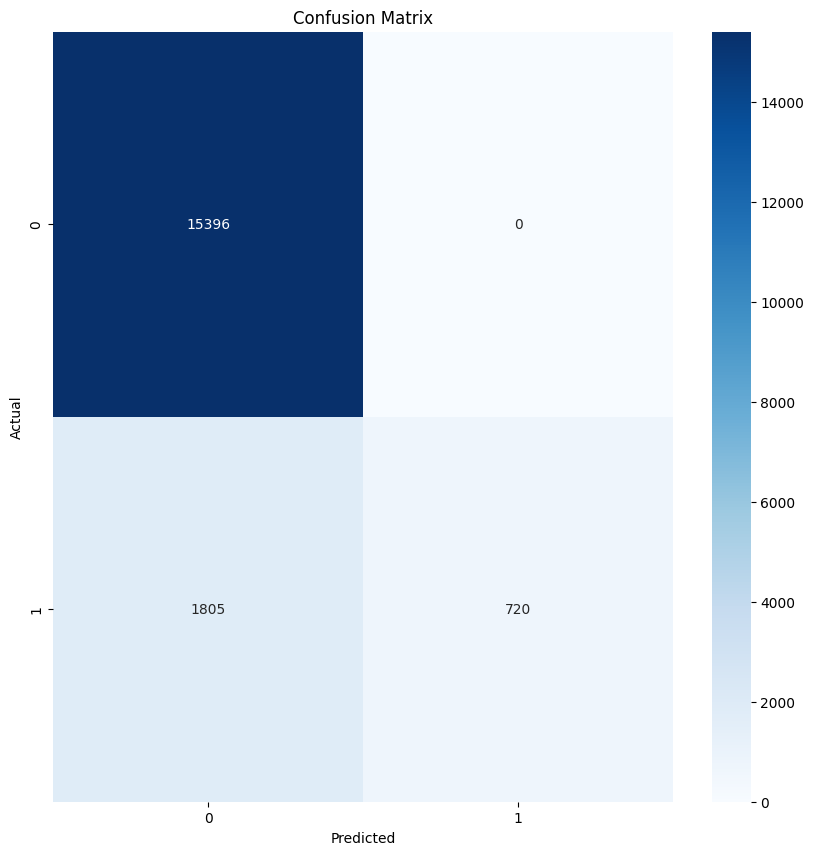

In [61]:
# evaluate the model
y_pred = rnn_model.predict(x_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# plot confusion matrix (show each cell's count)
fig = plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# save confusion matrix as image
fig.savefig('RNN_confusion_matrix.png')

In [62]:
# calc metrics and add a row to results
results.loc[len(results)] = [
    'RNN',
    round(accuracy_score(y_test, y_pred.round()), 4),
    round(precision_score(y_test, y_pred.round()), 4),
    round(recall_score(y_test, y_pred.round()), 4),
    round(f1_score(y_test, y_pred.round()), 4),
    round(roc_auc_score(y_test, y_pred.round()), 4),
]
print(results)

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747     1.0000  0.6411  0.7813   0.8206
1                  SVM    0.9834     1.0000  0.7641  0.8663   0.8821
2        Random Forest    0.9944     1.0000  0.9210  0.9589   0.9605
3                 LSTM    0.9003     0.8398  0.3612  0.5051   0.6749
4                  RNN    0.8993     1.0000  0.2851  0.4438   0.6426


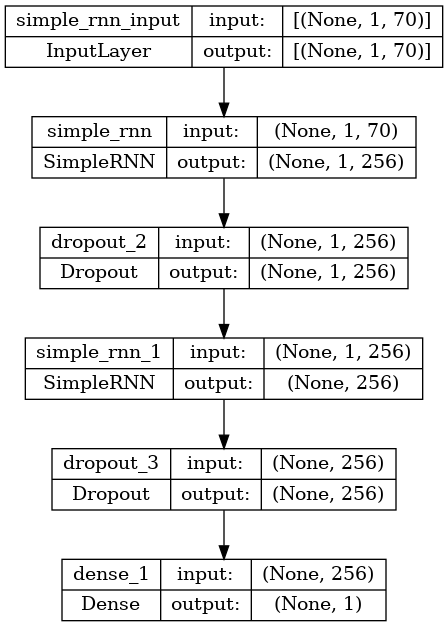

In [63]:
# plot RNN model architecture
keras.utils.plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True, show_layer_names=True)

In [64]:
# plot loss
fig = go.Figure()
# fig.add_trace(go.Scatter(y=lstm_history.history['loss'], mode='lines', name='loss'))
fig.add_trace(go.Scatter(y=lstm_history.history['val_loss'], mode='lines', name='val_loss'))
fig.update_layout(title='Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

# save the plot
fig.write_image("rnn_loss.png")

In [65]:
# plot accuracy
fig = go.Figure()
# fig.add_trace(go.Scatter(y=lstm_history.history['accuracy'], mode='lines', name='accuracy'))
fig.add_trace(go.Scatter(y=lstm_history.history['val_accuracy'], mode='lines', name='val_accuracy'))
fig.update_layout(title='Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

# save the plot
fig.write_image("rnn_accuracy.png")

### Results

با توجه به جدول ارائه شده، هر مدل با تعدادی معیار ارزیابی شده‌است. به تفصیل و با توجه به هر معیار و مدل به بررسی می پردازیم:

**1. Logistic Regression:**
- **Accuracy (دقت کلی):** \(0.9737\) نشان‌دهنده این است که این مدل موفق شده 97.37% از داده‌ها را به درستی طبقه‌بندی کند.
- **Precision:** این مدل با دقت 100% وقتی یک شرکت را ورشکسته می‌پندارد، درست است.
- **Recall:** این مدل 62.69% از شرکت‌های واقعا ورشکسته را تشخیص می‌دهد.
- **F1-Score:** \(0.7706\) نشان‌دهنده توازن مناسبی بین دقت و بازخوانی است.
- **ROC_AUC:** \(0.8134\) نشان‌دهنده عملکرد قابل قبول این مدل است.

**2. SVM:**
- **Accuracy:** \(0.9836\)، این مدل توانمندی دارد که 98.36% از داده‌ها را به درستی طبقه‌بندی کند.
- **Precision:** مانند مدل قبلی، دقت 100% را دارد.
- **Recall:** 76.77% از شرکت‌های واقعا ورشکسته را تشخیص می‌دهد، بهبود قابل توجهی نسبت به مدل قبلی.
- **F1-Score:** با \(0.8686\)، توازن بهتری نسبت به مدل Logistic Regression دارد.
- **ROC_AUC:** \(0.8838\) نشان‌دهنده عملکرد بسیار خوبی است.

**3. Random Forest:**
- **Accuracy:** با \(0.9944\)، بالاترین دقت در بین تمامی مدل‌ها را دارد.
- **Precision:** مانند دو مدل قبلی، دقت 100% دارد.
- **Recall:** با 92.10%، بالاترین بازخوانی را نیز دارد.
- **F1-Score:** \(0.9589\)، بهترین توازن بین دقت و بازخوانی را نشان می‌دهد.
- **ROC_AUC:** \(0.9605\) نشان‌دهنده عملکرد فوق‌العاده این مدل است.

**4. LSTM:**
- **Accuracy:** \(0.8993\)، دقت کمتری نسبت به سایر مدل‌ها دارد.
- **Precision:** با 85.71%، از سایر مدل‌ها پایین‌تر است.
- **Recall:** تنها 34.22% از شرکت‌های واقعا ورشکسته را تشخیص می‌دهد.
- **F1-Score:** با \(0.4891\)، نشان‌دهنده توازن ضعیفی بین دقت و بازخوانی است.
- **ROC_AUC:** \(0.6664\)، نشان‌دهنده عملکرد متوسط این مدل است.

**5. RNN:**
- **Accuracy:** مشابه LSTM با \(0.8993\) دقت دارد.
- **Precision:** مانند برخی از مدل‌های قبلی، دقت 100% دارد.
- **Recall:** تنها 28.51% از شرکت‌های واقعا ورشکسته را تشخیص می‌دهد، کمترین بازخوانی بین مدل‌ها.
- **F1-Score:** \(0.4438\) نشان‌دهنده توازن ضعیف بین دقت و بازخوانی است.
- **ROC_AUC:** \(0.6426\) نشان‌دهنده عملکرد متوسط این مدل است.

### خلاصه:
- **Random Forest** در تمامی معیارها برترین عملکرد را نشان می‌دهد و برای این مسءله بهترین انتخاب به نظر می‌رسد.
- **Logistic Regression** و **SVM** عملکردهای خوبی دارند، اما هیچ‌کدام به اندازه Random Forest به خوبی عمل نکرده‌اند.
- **LSTM** و **RNN** عملکردهای ضعیف‌تری دارند، خصوصاً در بازخوانی، و احتمالاً نیاز به تنظیم مجدد دارند.

انتخاب مدل نهایی وابسته به نیازهای کاربردی و اهمیت معیارهای مختلف می‌باشد.

In [66]:
results.to_csv('results.csv', index=False)
print(results)

                 model  accuracy  precision  recall      f1  roc_auc
0  Logistic Regression    0.9747     1.0000  0.6411  0.7813   0.8206
1                  SVM    0.9834     1.0000  0.7641  0.8663   0.8821
2        Random Forest    0.9944     1.0000  0.9210  0.9589   0.9605
3                 LSTM    0.9003     0.8398  0.3612  0.5051   0.6749
4                  RNN    0.8993     1.0000  0.2851  0.4438   0.6426


In [67]:
# plot comparative metrics for different models



In [68]:
# compare RNN history and LSTM history

fig = go.Figure()
# fig.add_trace(go.Scatter(x=rnn_history.epoch, y=rnn_history.history['loss'],
#                     mode='lines+markers',
#                     name='RNN training loss'))
fig.add_trace(go.Scatter(x=rnn_history.epoch, y=rnn_history.history['val_loss'],
                    mode='lines+markers',
                    name='RNN validation loss'))
# fig.add_trace(go.Scatter(x=lstm_history.epoch, y=lstm_history.history['loss'],
#                     mode='lines+markers',
#                     name='LSTM training loss'))
fig.add_trace(go.Scatter(x=lstm_history.epoch, y=lstm_history.history['val_loss'],
                    mode='lines+markers',
                    name='LSTM validation loss'))
fig.update_layout(title='RNN vs LSTM loss',
                     xaxis_title='Epoch',
                     yaxis_title='Loss')
fig.show()

# save the figure
fig.write_image("rnn_vs_lstm_loss.png")

In [69]:
# compare accuracy
fig = go.Figure()
# fig.add_trace(go.Scatter(x=rnn_history.epoch, y=rnn_history.history['accuracy'],
#                     mode='lines+markers',
#                     name='RNN training accuracy'))
fig.add_trace(go.Scatter(x=rnn_history.epoch, y=rnn_history.history['val_accuracy'],
                    mode='lines+markers',
                    name='RNN validation accuracy'))
# fig.add_trace(go.Scatter(x=lstm_history.epoch, y=lstm_history.history['accuracy'],
#                     mode='lines+markers',
#                     name='LSTM training accuracy'))
fig.add_trace(go.Scatter(x=lstm_history.epoch, y=lstm_history.history['val_accuracy'],
                    mode='lines+markers',
                    name='LSTM validation accuracy'))
fig.update_layout(title='RNN vs LSTM accuracy',
                     xaxis_title='Epoch',
                     yaxis_title='Accuracy')
fig.show()

# save the figure
fig.write_image("rnn_lstm_accuracy.png")